In [1]:
import os

#add the root directory
os.chdir('../')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from loader import *
import h5py
import matplotlib.ticker as ticker
import matplotlib.transforms as transforms
import matplotlib.lines as mlines
from PCAfold import normalized_variance_derivative, cost_function_normalized_variance_derivative
import re
from matplotlib import gridspec
import matplotlib.cm as cm
from matplotlib.lines import Line2D

# Figure 5: Heuristic vs. optimized PV for cost and MSE

In [3]:
path_variance = "data-files/costs/"

name_heuristic = "variance_Xu-bw_-6_2_100-dataset_autoignition.npy"
name_optimized = "variance_Tr0D-2s_s2-bw_-6_2_100-dataset_autoignition.npy"

penalty_function = 'log-sigma-over-peak'
power = 4
vertical_shift = 1

variance_heuristic = np.load(f"{path_variance}{name_heuristic}", allow_pickle=True).item()
variance_optimized = np.load(f"{path_variance}{name_optimized}", allow_pickle=True).item()

(derivative_heuristic, bandwidth_values_heuristic, max_derivative_heuristic) = normalized_variance_derivative(variance_heuristic)
(derivative_optimized, bandwidth_values_optimized, max_derivative_optimized) = normalized_variance_derivative(variance_optimized)

keys = ['H2O2', 'H2O', 'H2', 'HO2', 'N2O', 'NO2', 'NO', 'O2', 'OH', 'T', 'PV1']

costsHeuristic = cost_function_normalized_variance_derivative(variance_heuristic,
                                                            penalty_function=penalty_function,
                                                            power=power,
                                                            vertical_shift=vertical_shift,
                                                            norm=None)
costsOptimized = cost_function_normalized_variance_derivative(variance_optimized,
                                                            penalty_function=penalty_function,
                                                            power=power,
                                                            vertical_shift=vertical_shift,
                                                            norm=None)

In [4]:
MSEheuristic = np.load("paper/data/MSE_QoIs_val_NN_heuristic_autoignition_s7_epo500_lr0.01_scaleManifoldTrue.npy")
MSEoptimized = np.load("paper/data/MSE_QoIs_val_NN_Tr0D-2s_autoignition_s7_epo500_lr0.01_scaleManifoldTrue.npy")

C:\Windows\Temp\ipykernel_22752\1923068425.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greys = cm.get_cmap('Greys')


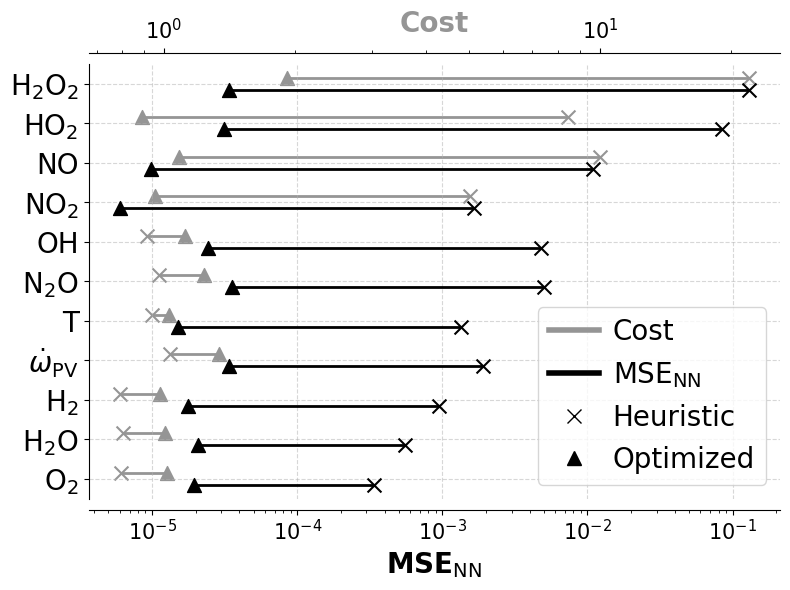

In [6]:
save = True
pathSave = "C:/Users/admin/Documents/PhD-ULB/Figures/2024-PV-optimization/Paper/EnergyAndAI/"
nameSave = "Figure 5 - cost and MSE heuristic and optimized - Xu vs 2s_s2 - MSE NN scaleManifold - lr 0.01 and logOrder - no spine"

keys = ['H2O2', 'H2O', 'H2', 'HO2', 'N2O', 'NO2', 'NO', 'O2', 'OH', 'T', '$\dot{\omega}_{\mathrm{PV}}$']
keys = [k.replace("2", "$_2$") for k in keys]

greys = cm.get_cmap('Greys')

# Convert to numpy arrays
MSE_heuristic = np.array(MSEheuristic)
MSE_optimized    = np.array(MSEoptimized)
Cost_heuristic = np.array(costsHeuristic)
Cost_optimized    = np.array(costsOptimized)
features = np.array(keys)

# Compute difference in MSE (absolute change)
delta_MSE = np.abs(np.log(MSE_optimized) - np.log(MSE_heuristic))

# Sort features by delta_MSE (largest first)
order = np.argsort(delta_MSE)

# Reorder all arrays
features_sorted = features[order]
MSE_heuristic_sorted = MSE_heuristic[order]
MSE_optimized_sorted = MSE_optimized[order]
Cost_heuristic_sorted = Cost_heuristic[order]
Cost_optimized_sorted = Cost_optimized[order]

# Sub-line vertical offsets
subline_offset = 0.15

# Create figure
fig, ax_mse = plt.subplots(figsize=(8, 6))

# Top axis for Cost
ax_cost = ax_mse.twiny()

# Plot lines with different markers
for i, feature in enumerate(features_sorted):
    y_center = i
    
    # MSE sub-line
    y = y_center - subline_offset
    ax_mse.plot([MSE_heuristic_sorted[i], MSE_optimized_sorted[i]], [y, y],
                color="k", linewidth=2)
    # Markers
    ax_mse.scatter(MSE_heuristic_sorted[i], y, color="k", marker="x", s=100, zorder=4)
    ax_mse.scatter(MSE_optimized_sorted[i], y, color="k", marker="^", s=100, zorder=5)
    
    # Cost sub-line
    y = y_center + subline_offset
    ax_cost.plot([Cost_heuristic_sorted[i], Cost_optimized_sorted[i]], [y, y],
                 color=greys(0.5), linewidth=2)
    # Markers
    ax_cost.scatter(Cost_heuristic_sorted[i], y, color=greys(0.5), marker="x", s=100, zorder=1)
    ax_cost.scatter(Cost_optimized_sorted[i], y, color=greys(0.5), marker="^", s=100, zorder=0)

# Set y-axis
ax_mse.set_yticks(range(len(features_sorted)))
ax_mse.set_yticklabels(features_sorted, fontsize=20)

# Labels and title
ax_mse.set_xlabel("MSE$_{\mathrm{NN}}$", fontsize=20, fontweight = "bold")
ax_cost.set_xlabel("Cost", fontsize=20, color = greys(0.5), labelpad = -10, fontweight = "bold")

# Grid only for bottom axis
ax_mse.grid(axis='both', linestyle='--', alpha=0.5)

# Adjust y-limits
ax_mse.set_ylim(-0.5, len(features_sorted) - 0.5)

# Optional: log scales
ax_mse.set_xscale("log")
ax_cost.set_xscale("log")

ax_mse.tick_params(axis = "x", labelsize = 15)
ax_cost.tick_params(axis = "x", labelsize = 15)

# Legend with markers
legend_elements = [
    Line2D([0], [0], color=greys(0.5), linestyle="-", lw=4, label="Cost"),
    Line2D([0], [0], color="k", linestyle="-", lw=4, label="MSE$_{\mathrm{NN}}$"),
    Line2D([0], [0], color="k", marker="x", lw=0, markersize=10, label="Heuristic"),
    Line2D([0], [0], color="k", marker="^", lw=0, markersize=10, label="Optimized")
    
]
ax_mse.legend(handles=legend_elements, ncol = 1, fontsize=20, loc="lower right", handletextpad=0.5, handlelength=1.8)

ax_mse.set_zorder(1)   # bottom axis
ax_cost.set_zorder(0)  # top axis
ax_mse.patch.set_visible(False)

ax_mse.spines['right'].set_visible(False)
ax_mse.spines['top'].set_visible(False)
ax_cost.spines['right'].set_visible(False)
ax_cost.spines['left'].set_visible(False)
ax_cost.spines['bottom'].set_visible(False)

offset = 8

ax_mse.spines['bottom'].set_position(('outward', offset))
ax_cost.spines['top'].set_position(('outward', offset))

plt.tight_layout()
if save:
    plt.savefig(pathSave + nameSave + ".png", dpi=300, bbox_inches = "tight")
    plt.savefig(pathSave + nameSave + ".pdf", bbox_inches = "tight")
plt.show()
